# Metric Analysis for ECON model

In [1]:
%reload_ext autoreload
%autoreload 2

# from common.metrics.gradient import Gradient
import torch
import torchinfo
import numpy as np
import pytorch_lightning as pl 
import matplotlib.pyplot as plt
import ast
import os
import sys

# import modules from ECON model
module_path = os.path.abspath(os.path.join('../../workspace/models/econ/code/')) # or the path to your source code
sys.path.insert(0, module_path)
from q_autoencoder import AutoEncoder
from autoencoder_datamodule import AutoEncoderDataModule

# import modules from common metrics
module_path = os.path.abspath(os.path.join('../../workspace/common/metrics/')) # or the path to your source code
sys.path.insert(0, module_path)
from gradient import Gradient
from hessian import Hessian
from CKA import CKA
from neural_efficiency import NeuralEfficiency
from fisher import Fisher




/home/tbaldi/miniconda3/envs/loss_landscape/lib/python3.8/site-packages/torchvision/io/image.py:11: UserWarning: Failed to load image Python extension: libtorch_cuda_cu.so: cannot open shared object file: No such file or directory
  warn(f"Failed to load image Python extension: {e}")


Select the desired ECON model:

In [2]:
base_path = "/data/tbaldi/checkpoint/"
batch_size = 1024
learning_rate = 0.0015625
precision = 8
size = 'small'

In [3]:
def load_model(path, batch_size, learning_rate, precision, size):
    model_path = path + f'bs{batch_size}_lr{learning_rate}/ECON_{precision}b/{size}/net_1_best.pkl'
    
    # load the model
    model = AutoEncoder(
        quantize=(precision < 32),
        precision=[
            precision,
            precision,
            precision+3
        ],
        learning_rate=learning_rate,
        econ_type=size
    )
    
    # to set the map location
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    
    model(torch.randn((1, 1, 8, 8)))  # Update tensor shapes 
    model_param = torch.load(model_path, map_location=device)
    model.load_state_dict(model_param['state_dict'])
    
    return model


model = load_model(base_path, batch_size, learning_rate, precision, size)
torchinfo.summary(model, input_size=(1, 1, 8, 8))  # (B, C, H, W)     

Layer (type:depth-idx)                   Output Shape              Param #
AutoEncoder                              [1, 1, 8, 8]              --
├─QuantizedEncoder: 1-1                  [1, 16]                   --
│    └─QuantAct: 2-1                     [1, 1, 8, 8]              --
│    └─QuantConv2d: 2-2                  [1, 1, 4, 4]              20
│    └─ReLU: 2-3                         [1, 1, 4, 4]              --
│    └─QuantAct: 2-4                     [1, 1, 4, 4]              --
│    └─Flatten: 2-5                      [1, 16]                   --
│    └─QuantLinear: 2-6                  [1, 16]                   272
│    └─ReLU: 2-7                         [1, 16]                   --
├─Sequential: 1-2                        [1, 1, 8, 8]              --
│    └─Linear: 2-8                       [1, 128]                  2,176
│    └─ReLU: 2-9                         [1, 128]                  --
│    └─Unflatten: 2-10                   [1, 8, 4, 4]              --
│    └─Conv

Setup the data loader:

In [4]:
data_path = '../../data/ECON/Elegun'
processed_file = 'nELinks5.npy'

def get_data_module(batch_size):
    data_module = AutoEncoderDataModule(
        data_dir=data_path,
        data_file=os.path.join(data_path, processed_file),
        batch_size=batch_size,
        num_workers=4
        )
    # checek if we have processed the data
    if not os.path.exists(os.path.join(data_path, processed_file)):
        print('Processing the data...')
        data_module.process_data(save=True)

    data_module.setup(0)
    return data_module

data_module = get_data_module(batch_size)

Loaded shaped data shape: (1740950, 1, 8, 8)
Loaded shaped data datatype: float32


Model performances:

In [5]:
trainer = pl.Trainer(
        max_epochs=5,
        accelerator="auto",
        devices=1
    )

def compute_EMD(bs, lr, size, precision, load=True):
    if load:
        print("Loading the EMD...")
        emd_path = base_path + f'bs{bs}_lr{lr}/ECON_{precision}b/{size}/{size}_emd_1.txt'
        # load the achieved EMD of the model
        emd = None
        try:
            emd_file = open(emd_path)
            emd_text = emd_file.read()
            emd = ast.literal_eval(emd_text)
            emd = emd[0]['AVG_EMD']
            emd_file.close()
            return emd
        except Exception as e:
            print("ATTENTION: not able to open the file with the EMD content!")
        
    print("Computing the EMD...")
    # load the model 
    model = load_model(base_path, bs, lr, precision, size)
    # get the data loader
    data_module = get_data_module(bs)
    _, val_sum = data_module.get_val_max_and_sum()
    model.set_val_sum(val_sum)
    data_module.setup("test")
    avg_emd = trainer.test(model, dataloaders=data_module.test_dataloader(), verbose=False)
    return avg_emd
    



GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


## (Estimated) Fisher trace

In [6]:
_, val_loader = data_module.dataloaders()

metric = Fisher(
    model=model,
    data_loader=val_loader,
    optimizer=model.configure_optimizers(),
    target_layers=['encoder.conv', 'encoder.enc_dense']
)

metric.compute()

Computing the Fisher estimated trace...


{'EF_trace': {'encoder.conv': 0.0004712590985983348,
  'encoder.enc_dense': 0.00040848579399746537}}

## Hessian 

In [7]:

_, val_loader = data_module.dataloaders(max_batches=100)

print(len(val_loader))
metric = Hessian(
    model=model,
    data_loader=val_loader,
    loss=model.loss)

results = metric.compute()
len(results)

1
Computing the hessian metrics...


/home/tbaldi/miniconda3/envs/loss_landscape/lib/python3.8/site-packages/torch/autograd/__init__.py:200: UserWarning: Using backward() with create_graph=True will create a reference cycle between the parameter and its gradient which can cause a memory leak. We recommend using autograd.grad when creating the graph to avoid this. If you have to use this function, make sure to reset the .grad fields of your parameters to None after use to break the cycle and avoid the leak. (Triggered internally at ../torch/csrc/autograd/engine.cpp:1151.)
  Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass


trace: ([tensor(21.4213), tensor(50.1982), tensor(32.4628), tensor(27.9331), tensor(108.8410), tensor(22.6781), tensor(114.8436), tensor(96.5289), tensor(37.7159), tensor(5.6954), tensor(278.8664), tensor(99.0729), tensor(53.9362), tensor(10.4557), tensor(90.7464), tensor(9.5632), tensor(47.7793), tensor(177.5474), tensor(21.2044), tensor(102.7833), tensor(12.1959), tensor(39.0840), tensor(41.7090), tensor(62.3207), tensor(30.8330), tensor(28.5331), tensor(8.7009), tensor(42.2599), tensor(25.1581), tensor(25.0077), tensor(9.2595), tensor(115.2031), tensor(34.4827), tensor(45.4585), tensor(6.2695), tensor(272.5339), tensor(42.6834), tensor(47.4275), tensor(231.9359), tensor(15.1256), tensor(155.7421), tensor(29.4414), tensor(266.4585), tensor(22.4278), tensor(18.9080), tensor(51.3759), tensor(9.8948), tensor(41.4964), tensor(47.1707), tensor(8.6851), tensor(49.4013), tensor(13.8226), tensor(224.5432), tensor(15.4405), tensor(20.7559), tensor(166.4109), tensor(103.2655), tensor(49.0685),

0

## CKA similarity

Extract the features from each layer of the model:

In [8]:
model = load_model(base_path, 1024, 0.003125, 8, 'small')
data_module = get_data_module(batch_size)

Loaded shaped data shape: (1740950, 1, 8, 8)
Loaded shaped data datatype: float32


In [9]:
metric = CKA(model, 
             data_module.test_dataloader(),
             activation_layers=['encoder.conv', 'encoder.enc_dense'])

result = metric.compute()


Computing the CKA similarity...
CKA matrix:                    encoder.conv  encoder.enc_dense
encoder.conv       3.848318e-08       4.046033e-01
encoder.enc_dense  4.046035e-01      -3.331753e-08
average CKA: 0.4046034104675882


/home/tbaldi/loss_landscape_taxonomy/workspace/common/metrics/CKA.py:137: UserWarning: Warning: CKA has a wrong value!
  warnings.warn(f"Warning: CKA has a wrong value!")


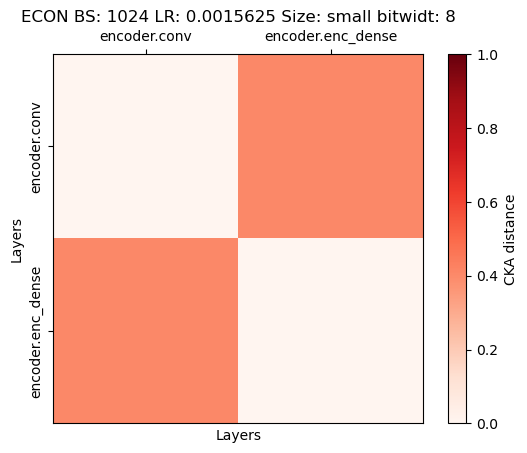

In [10]:
def plot_cka_heatmap(cka_values, title, x_label='Layers', y_label='Layers'):
    # Create a heatmap
    ax = plt.imshow(cka_values.values, 
            cmap='Reds', 
            interpolation='nearest',
            vmin=0,
            vmax=1)

    # Customize the plot
    plt.colorbar(label='CKA distance')
    plt.title(title)
    plt.xlabel(x_label)
    plt.ylabel(y_label)

    # Set axis ticks based on the dimensions
    plt.xticks(np.arange(len(cka_values.columns)), cka_values.columns, rotation='horizontal')
    plt.yticks(np.arange(len(cka_values.index)), cka_values.index, rotation='vertical', va='center')
    
    
    plt.tick_params(top=True, labeltop=True, bottom=False, labelbottom=False)

    # Display the plot
    plt.show()
    
plot_cka_heatmap(result['cka_dist'], 
                 f"ECON BS: {batch_size} LR: {learning_rate} Size: {size} bitwidt: {precision}")

In [11]:
model_small = load_model(base_path, 1024, learning_rate, 8, 'small')
data_module_small = get_data_module(1024)

model_baseline = load_model(base_path, 1024, learning_rate, 2, 'small')
data_module_baseline = get_data_module(1024)

activation_layers=['encoder.relu1', 'encoder.relu2']

metric = CKA(model_small, 
             data_module_small.test_dataloader(),
             activation_layers=activation_layers)

result = metric.compare(model_baseline, 
                        data_module_baseline.test_dataloader(), 
                        activation_layers)


plot_cka_heatmap(result['cka_dist'], 
                 f"ECON BS: {batch_size} LR: {learning_rate} size: {size}\n 8 bit VS 2 bit",
                 x_label='model 2',
                 y_label='model 1')

Loaded shaped data shape: (1740950, 1, 8, 8)
Loaded shaped data datatype: float32


FileNotFoundError: [Errno 2] No such file or directory: '/data/tbaldi/checkpoint/bs1024_lr0.0015625/ECON_2b/small/net_1_best.pkl'

## Neural Efficiency

In [ ]:
model = load_model(base_path, 1024, 0.003125, 8, 'small')
data_module = get_data_module(1)
emd = compute_EMD(1024, 0.003125, 'small', 8)

Loaded shaped data shape: (1740950, 1, 8, 8)
Loaded shaped data datatype: float32
Loading the EMD...


In [ ]:
metric = NeuralEfficiency(model.encoder, data_module.test_dataloader(), performance=emd)
result = metric.compute(beta=-2)

result

Computing the Neural efficiency...


/home/tbaldi/loss_landscape_taxonomy/workspace/common/metrics/neural_efficiency.py:95: UserWarning: Attention: the layer conv has tuple as features!
  warnings.warn(f"Attention: the layer " + name + " has tuple as features!")
/home/tbaldi/loss_landscape_taxonomy/workspace/common/metrics/neural_efficiency.py:91: UserWarning: Attention: the layer conv.conv has None features!
  warnings.warn(f"Attention: the layer " + name + " has None features!")


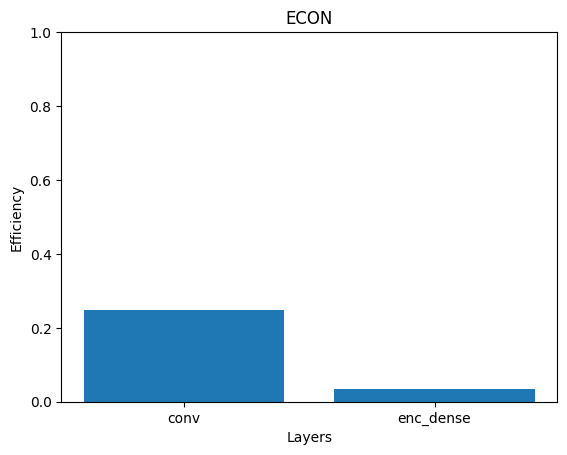

In [ ]:
def plot_neural_efficiency_per_layer(neural_efficiency_values, 
                                     title, 
                                     x_label='Layers', 
                                     y_label='Efficiency'):
    # Create a heatmap
    plt.bar(neural_efficiency_values.keys(), 
            neural_efficiency_values.values())

    plt.ylim(0, 1)
    
    plt.xlabel(x_label)
    plt.ylabel(y_label)
    plt.title(title)

    # Display the plot
    plt.show()
    

plot_neural_efficiency_per_layer(result['layers_efficiency'], 'ECON')